# Source Panel Method

In [192]:
%run resources/resources.ipynb

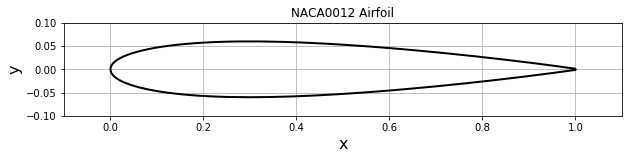

In [193]:
# read the geometry from a data file
naca_filepath = os.path.join('resources', 'naca0012.dat')
with open(naca_filepath, 'r') as filename:
    x, y = np.loadtxt(filename, dtype=float, delimiter='\t', unpack=True)
    
# plot the geometry
width = 10
plt.figure(figsize=(width, width))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linewidth=2, linestyle='-')
plt.axis('scaled', adjustable='box')
plt.title('NACA0012 Airfoil')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1);

In [194]:
def define_panels(x, y, N=40):
    """
    Discretizes the geometry into panels using the 'cosine' method.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 40.
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects
        The discretization of the geometry into panels.
    """
    
    R = (x.max()-x.min())/2
    x_center = (x.max()+x.min())/2
    x_circle = x_center + R*np.cos(np.linspace(0, 2*np.pi, N+1))
    
    x_ends = np.copy(x_circle)
    y_ends = np.empty_like(x_ends)
    
    x, y = np.append(x, x[0]), np.append(y, y[0])
    
    # compute y-coordinates of end points
    I = 0
    for i in range(N):
        while I < len(x)-1:
            if (x[I] <= x_ends[i] <= x[I+1]) or (x[I+1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        
        a = (y[I+1]-y[I])/(x[I+1]-x[I])
        b = y[I+1] - a*x[I+1]
        y_ends[i] = a*x_ends[i] + b
    y_ends[N] = y_ends[0]
        
    panels = np.empty(N, dtype=object)
    
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
            
    return panels

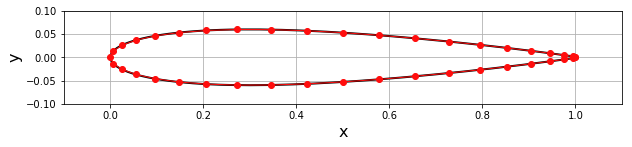

In [195]:
# let's do this
N=40
panels = define_panels(x, y)

# plot geometry and panels
width = 10
plt.figure(figsize=(width, width))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels], panels[0].xa),
         np.append([panel.ya for panel in panels], panels[0].ya),
         linestyle='-', linewidth=1, marker='o', markersize=6, color='#FF0D0D')
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1);

## Free stream conditions

In [196]:
# free stream instance
u_inf = 1.0
alpha = 0.0
fs = Freestream(u_inf, alpha)

## Flow tangency boundary condition

$$u_{n_i} = \frac{\partial}{\partial n_i}\left\lbrace\phi\left(x_{c_i},y_{c_i}\right)\right\rbrace = 0$$

i.e.

$$0 = U_\infty\cos\beta_i + \frac{\sigma_i}{2} + \sum_{j=1, j\neq i}^{N_p}\frac{\sigma_j}{2\pi}I_j$$

where

$$I_j = \int\frac{\left(x_{c_i} - x_j\left(s_j\right)\right)\cos\beta_i + \left(y_{c_i} - y_j\left(s_j\right)\right)\sin\beta_i}{\left(x_{c_i} - x_j\left(s_j\right)\right)^2 + \left(y_{c_i} - y_j\left(s_j\right)\right)^2}ds_j$$

In [197]:
def integral(x, y, panel, dxdz, dydz):
    """
    Evaluates the contribution of a panel at one point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Source panel which contribution is evaluated.
    dxdz: float
        Derivative of x in the z-direction.
    dydz: float
        Derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at the given target point.
    """
    def integrand(s):
        return ( ((x - (panel.xa - np.sin(panel.beta)*s))*dxdz
                   +(y - (panel.ya + np.cos(panel.beta)*s))*dydz)
                /((x - (panel.xa - np.sin(panel.beta)*s))**2
                 +(y - (panel.ya + np.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [198]:
def build_matrix(panels):
    """
    Builds the source matrix.
    
    Parameters
    ----------
    panels: 1D array of Panel object
        The source panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        The source matrix (NxN matrix; N is the number of panels).
    """
    N = len(panels)
    A = np.empty((N, N), dtype=float)
    np.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 1.0/(2.0*np.pi)*integral(p_i.xc, p_i.yc, p_j, np.cos(p_i.beta), np.sin(p_i.beta))
    
    return A


def build_rhs(panels, freestream):
    """
    Builds the RHS of the linear system.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        RHS of the linear system.
    """
    b = np.empty(len(panels), dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf*np.cos(freestream.alpha - panel.beta)
        
    return b

In [199]:
A = build_matrix(panels)
b = build_rhs(panels, fs)

# solve linear system
sigma = np.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

## Surface Pressure Coefficient

$$C_{p_i} = 1 - \left(\frac{u_{t_i}}{U_\infty}\right)^2$$

In [200]:
def get_tangential_velocity(panels, freestream):
    """
    Computes the tangential velocity on the surface of the panels.
    
    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    """
    N = len(panels)
    A = np.empty((N,N), dtype=float)
    np.fill_diagonal(A, 0.0)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 1.0/(2.0*np.pi)*integral(p_i.xc, p_i.yc, p_j, -math.sin(p_i.beta), math.cos(p_i.beta))
                
    b = freestream.u_inf*np.sin([freestream.alpha - panel.beta for panel in panels])
    
    sigma = np.array([panel.sigma for panel in panels])
    
    vt = np.dot(A, sigma) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [201]:
get_tangential_velocity(panels, fs)

In [202]:
def get_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients on the panels.
    
    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [203]:
get_pressure_coefficient(panels, fs)

## Theoretical Solution

In [204]:
voverVsquared = np.array([0, 0.64, 1.01, 1.241, 1.378, 1.402, 1.411, 1.411, 1.399, 1.378, 1.35, 1.288, 1.228, 1.166, 1.109, 1.044, 0.956, 0.906, 0])

In [205]:
print(voverVsquared)

[ 0.     0.64   1.01   1.241  1.378  1.402  1.411  1.411  1.399  1.378
  1.35   1.288  1.228  1.166  1.109  1.044  0.956  0.906  0.   ]


In [206]:
xtheory = np.array([0, 0.5, 1.25, 2.5, 5.0, 7.5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 95, 100])
xtheory /= 100
print(xtheory)

[ 0.      0.005   0.0125  0.025   0.05    0.075   0.1     0.15    0.2     0.25
  0.3     0.4     0.5     0.6     0.7     0.8     0.9     0.95    1.    ]


## Plotting the results

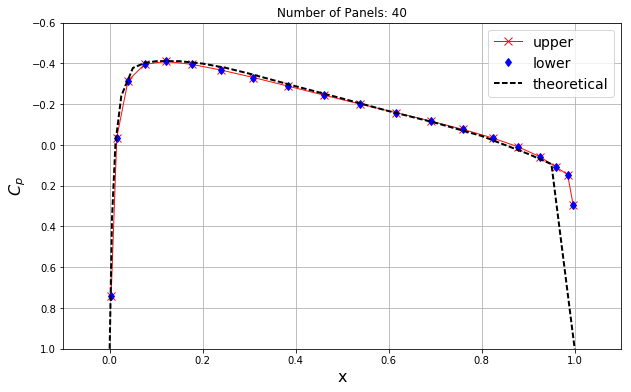

In [207]:
# plot the surface pressure coefficient
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels if panel.loc == 'upper'],
         [panel.cp for panel in panels if panel.loc == 'upper'],
         label='upper', color='#FF0D0D', linewidth=1, marker='x', markersize=8)
plt.plot([panel.xc for panel in panels if panel.loc == 'lower'],
         [panel.cp for panel in panels if panel.loc == 'lower'],
         label='lower', color='b', linewidth=0, marker='d', markersize=6)
plt.plot(xtheory, 1-voverVsquared, label='theoretical', color='k', linestyle='--', linewidth=2)
plt.legend(loc='best', prop={'size':14})
plt.xlim(-0.1, 1.1)
plt.ylim(1.0, -0.6)
plt.title('Number of Panels: %d' % N);

### Accuracy check

In [208]:
accuracy = sum([panel.sigma*panel.length for panel in panels])
print('--> sum of source/sink strengths: {}'.format(accuracy))

--> sum of source/sink strengths: 0.004617031175283087


## Streamlines onto a mesh grid

In [209]:
def get_velocity_field(panels, freestream, X, Y):
    """
    Computes the velocity field on a given 2D mesh.
    
    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    X: 2D Numpy array of floats
        x-coordinates of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    u: 2D Numpy array of floats
        x-component of the velocity vector field.
    v: 2D Numpy array of floats
        y-component of the velocity vector field.
    """
    # freestream contribution
    u = freestream.u_inf * np.cos(freestream.alpha) * np.ones_like(X, dtype=float)
    v = freestream.u_inf * np.sin(freestream.alpha) * np.ones_like(X, dtype=float)
    # add the contribution from each source (superposition powers!!!)
    vec_intregral = np.vectorize(integral)
    for panel in panels:
        u += panel.sigma / (2.0 * np.pi) * vec_intregral(X, Y, panel, 1, 0)
        v += panel.sigma / (2.0 * np.pi) * vec_intregral(X, Y, panel, 0, 1)
    
    return u, v

In [210]:
nx, ny = 20, 20
x_start, x_end = -1.0, 2.0
y_start, y_end = -0.3, 0.3
X, Y = np.meshgrid(np.linspace(x_start, x_end, nx), np.linspace(y_start, y_end, ny))
u, v = get_velocity_field(panels, fs, X, Y)

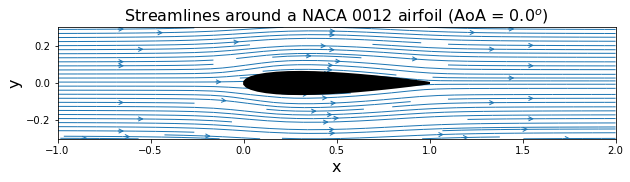

In [212]:
# plot velocity field
width = 10
plt.figure(figsize=(width, width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.streamplot(X, Y, u, v, density=1, linewidth=1, arrowsize=1, arrowstyle='->')
plt.fill([panel.xc for panel in panels], [panel.yc for panel in panels], color='k', linestyle='solid', linewidth=2, zorder=2)
plt.axis('scaled', adjustable='box')
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)
plt.title('Streamlines around a NACA 0012 airfoil (AoA = ${}^o$)'.format(alpha), fontsize=16);

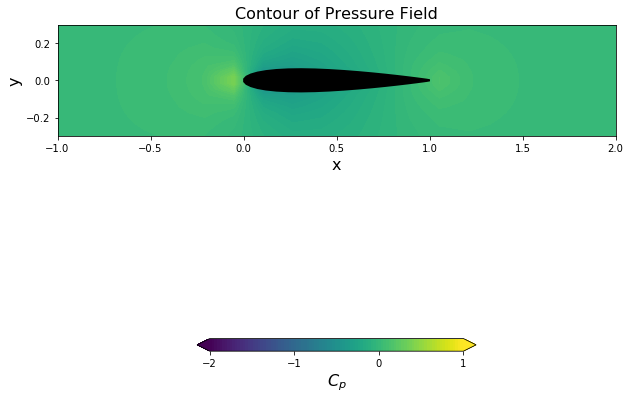

In [213]:
# compute the pressure field
cp = 1.0 - (u**2 + v**2)/fs.u_inf**2

# plot
width = 10
plt.figure(figsize=(width, width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
contf = plt.contourf(X, Y, cp, levels = np.linspace(-2.0, 1.0, 100), extend='both')
cbar = plt.colorbar(contf, orientation='horizontal', shrink=0.5, pad=0.1, ticks=[-2.0, -1.0, 0.0, 1.0])
cbar.set_label('$C_p$', fontsize=16)
plt.fill([panel.xc for panel in panels], [panel.yc for panel in panels], color='k', linestyle='solid', linewidth=2, zorder=2)
plt.axis('scaled', adjustable='box')
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)
plt.title('Contour of Pressure Field', fontsize=16);